In [1]:
import pandas as pd
import os
from typing import List
import datetime

In [2]:

# Specify the directory path as a string
directory_path: str = 'data/231102'

# List to store the names of CSV files (each file name is a string)
csv_files: List[str] = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

# List to hold DataFrame objects
all_data: List[pd.DataFrame] = []

# Iterate over the list of file names
for file_name in csv_files:
    file_path: str = os.path.join(directory_path, file_name)  # Construct full file path
    df: pd.DataFrame = pd.read_csv(file_path)  # Read CSV into DataFrame
    all_data.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_data: pd.DataFrame = pd.concat(all_data)

In [3]:
combined_data['time'] = pd.to_datetime(combined_data['time']) 

combined_data.head()

,time,device,mac_id,rss,sector_id,zone_id
0,2023-11-02 13:27:30,APPLE,4F-01-2A-82-06-FC,-75,13,13
0,2023-11-02 14:22:55,APPLE,61-1C-C7-A5-82-0E,-67,1,5
1,2023-11-02 14:23:00,APPLE,61-1C-C7-A5-82-0E,-65,1,5
2,2023-11-02 14:23:10,APPLE,61-1C-C7-A5-82-0E,-69,1,5
3,2023-11-02 14:23:20,APPLE,61-1C-C7-A5-82-0E,-79,10,10


In [4]:
specific_date = '2023-11-02'
start_time = '14:00:00'
end_time = '15:00:00'

filtered_data = combined_data[
    (combined_data['time'].dt.date == pd.to_datetime(specific_date).date()) &
    (combined_data['time'].dt.time >= pd.to_datetime(start_time).time()) &
    (combined_data['time'].dt.time <= pd.to_datetime(end_time).time())
]

filtered_data

,time,device,mac_id,rss,sector_id,zone_id
0,2023-11-02 14:22:55,APPLE,61-1C-C7-A5-82-0E,-67,1,5
1,2023-11-02 14:23:00,APPLE,61-1C-C7-A5-82-0E,-65,1,5
2,2023-11-02 14:23:10,APPLE,61-1C-C7-A5-82-0E,-69,1,5
3,2023-11-02 14:23:20,APPLE,61-1C-C7-A5-82-0E,-79,10,10
4,2023-11-02 14:23:25,APPLE,61-1C-C7-A5-82-0E,-73,1,5
...,...,...,...,...,...,...
3,2023-11-02 14:58:25,APPLE,7F-24-98-B5-13-30,-83,11,15
4,2023-11-02 14:58:50,APPLE,7F-24-98-B5-13-30,-84,25,23
5,2023-11-02 14:59:05,APPLE,7F-24-98-B5-13-30,-77,12,14
6,2023-11-02 14:59:15,APPLE,7F-24-98-B5-13-30,-84,8,8


In [5]:
mac_counts = filtered_data.groupby('mac_id').size()

# Convert the Series to a dictionary (optional)
mac_counts_dict = mac_counts.to_dict()
mac_counts_dict.__len__()

2362

In [6]:
filtered_mac_counts_dict = {key: value for key, value in mac_counts_dict.items() if value >= 120}
filtered_mac_counts_dict.__len__()

809

In [7]:
mac_addresses_to_keep = list(filtered_mac_counts_dict.keys())

filtered_data = filtered_data[filtered_data['mac_id'].isin(mac_addresses_to_keep)]

In [8]:
grouped = filtered_data.groupby('mac_id')['zone_id'].apply(set)

# Convert to dictionary
mac_id_to_zone_id_dict = grouped.to_dict()

mac_id_to_zone_id_dict.__len__()

809

In [9]:
filtered_mac_id_to_zone_id_dict = {
    mac_id: zone_ids
    for mac_id, zone_ids in mac_id_to_zone_id_dict.items()
    # if len(zone_ids) >= 15
}
filtered_mac_id_to_zone_id_dict.__len__()

809

In [10]:
mac_ids_to_keep = list(filtered_mac_id_to_zone_id_dict.keys())

filtered_data = filtered_data[filtered_data['mac_id'].isin(mac_ids_to_keep)]

filtered_data

,time,device,mac_id,rss,sector_id,zone_id
0,2023-11-02 14:22:55,APPLE,61-1C-C7-A5-82-0E,-67,1,5
1,2023-11-02 14:23:00,APPLE,61-1C-C7-A5-82-0E,-65,1,5
2,2023-11-02 14:23:10,APPLE,61-1C-C7-A5-82-0E,-69,1,5
3,2023-11-02 14:23:20,APPLE,61-1C-C7-A5-82-0E,-79,10,10
4,2023-11-02 14:23:25,APPLE,61-1C-C7-A5-82-0E,-73,1,5
...,...,...,...,...,...,...
202,2023-11-02 14:34:30,APPLE,74-8F-41-B6-93-24,-66,7,7
203,2023-11-02 14:34:35,APPLE,74-8F-41-B6-93-24,-64,7,7
204,2023-11-02 14:34:55,APPLE,74-8F-41-B6-93-24,-76,7,7
205,2023-11-02 14:35:00,APPLE,74-8F-41-B6-93-24,-76,7,7


In [11]:
pivot_df = filtered_data.pivot_table(index='time', columns='mac_id', values='zone_id', aggfunc='first')
pivot_df = pivot_df.bfill().ffill()

In [12]:
# Number of columns in pivot_df
num_columns = len(pivot_df.columns)

# Create a list of integers [1, 2, 3, ..., num_columns]
new_column_names = list(range(1, num_columns + 1))

# Assign the new column names to pivot_df
pivot_df.columns = new_column_names

pivot_df

,1,2,3,4,5,6,7,8,9,10,...,800,801,802,803,804,805,806,807,808,809
time,,,,,,,,,,,,,,,,,,,,,
2023-11-02 14:00:00,7.0,10.0,2.0,5.0,14.0,13.0,3.0,19.0,12.0,7.0,...,23.0,3.0,8.0,14.0,19.0,14.0,1.0,5.0,5.0,18.0
2023-11-02 14:00:05,7.0,10.0,2.0,5.0,14.0,13.0,3.0,19.0,12.0,7.0,...,23.0,3.0,8.0,14.0,19.0,14.0,1.0,5.0,5.0,18.0
2023-11-02 14:00:10,7.0,10.0,2.0,5.0,14.0,13.0,3.0,19.0,12.0,7.0,...,23.0,3.0,8.0,13.0,19.0,14.0,1.0,5.0,5.0,18.0
2023-11-02 14:00:15,7.0,10.0,2.0,5.0,14.0,13.0,3.0,19.0,12.0,7.0,...,23.0,3.0,8.0,14.0,19.0,14.0,1.0,5.0,15.0,18.0
2023-11-02 14:00:20,7.0,10.0,2.0,5.0,14.0,13.0,3.0,19.0,12.0,7.0,...,23.0,3.0,8.0,14.0,19.0,14.0,1.0,5.0,15.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-02 14:59:40,11.0,10.0,4.0,5.0,20.0,13.0,23.0,19.0,17.0,11.0,...,20.0,3.0,8.0,14.0,19.0,23.0,7.0,18.0,1.0,18.0
2023-11-02 14:59:45,11.0,10.0,4.0,5.0,20.0,13.0,23.0,19.0,17.0,11.0,...,10.0,3.0,8.0,14.0,19.0,23.0,7.0,18.0,1.0,18.0
2023-11-02 14:59:50,11.0,10.0,4.0,5.0,20.0,13.0,23.0,19.0,17.0,11.0,...,20.0,3.0,8.0,14.0,19.0,23.0,7.0,18.0,1.0,18.0


In [13]:
def mode_agg(series):
    if len(series) > 0:
        return series.mode()[0]
    else:
        return pd.NA

In [14]:
resampled_df = pivot_df.resample('1T')

pivot_df = resampled_df.agg(mode_agg)

In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pivot_df[1]

time
2023-11-02 14:00:00     7.0
2023-11-02 14:01:00     7.0
2023-11-02 14:02:00     7.0
2023-11-02 14:03:00     7.0
2023-11-02 14:04:00     7.0
2023-11-02 14:05:00     7.0
2023-11-02 14:06:00     7.0
2023-11-02 14:07:00     7.0
2023-11-02 14:08:00     7.0
2023-11-02 14:09:00     1.0
2023-11-02 14:10:00    12.0
2023-11-02 14:11:00    12.0
2023-11-02 14:12:00    12.0
2023-11-02 14:13:00    12.0
2023-11-02 14:14:00    12.0
2023-11-02 14:15:00    12.0
2023-11-02 14:16:00     6.0
2023-11-02 14:17:00     6.0
2023-11-02 14:18:00    12.0
2023-11-02 14:19:00     1.0
2023-11-02 14:20:00     1.0
2023-11-02 14:21:00    12.0
2023-11-02 14:22:00     6.0
2023-11-02 14:23:00    12.0
2023-11-02 14:24:00     6.0
2023-11-02 14:25:00    11.0
2023-11-02 14:26:00    11.0
2023-11-02 14:27:00    11.0
2023-11-02 14:28:00    11.0
2023-11-02 14:29:00    11.0
2023-11-02 14:30:00    11.0
2023-11-02 14:31:00    11.0
2023-11-02 14:32:00    11.0
2023-11-02 14:33:00    11.0
2023-11-02 14:34:00    11.0
2023-11-02 14:3

In [16]:
zone_position_map = {
        1: (45, 45),
        2: (45, 119),
        3: (45, 193),
        4: (45, 267),
        5: (45, 341),
        6: (141, 45),
        7: (141, 119),
        8: (141, 193),
        9: (141, 267),
        10: (141, 341),
        11: (237, 45),
        12: (237, 119),
        13: (237, 193),
        14: (237, 267),
        15: (237, 341),
        16: (333, 45),
        17: (333, 119),
        18: (333, 193),
        19: (333, 267),
        20: (333, 341),
        21: (429, 45),
        22: (429, 119),
        23: (429, 193),
        23: (429, 267),
        24: (429, 341),
        25: (525, 45),
    }

In [17]:
transformed_df = pivot_df.map(lambda zone_id: zone_position_map.get(zone_id, (None, None)))
transformed_df

1           2           3          4    \
time                                                                 
2023-11-02 14:00:00  (141, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:01:00  (141, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:02:00  (141, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:03:00  (141, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:04:00  (141, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:05:00  (141, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:06:00  (141, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:07:00  (141, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:08:00  (141, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:09:00    (45, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:10:00  (237, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:11:00  (237, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:12:00  (237, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:13:00  (237, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:14:00  (237, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:15:00  (237, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:16:00   (141, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:17:00   (141, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:18:00  (237, 119)  (141, 267)   (45, 119)  (45, 341)   
2023-11-02 14:19:00    (45, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:20:00    (45, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:21:00  (237, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:22:00   (141, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:23:00  (237, 119)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:24:00   (141, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:25:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:26:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:27:00   (237, 45)  (141, 341)   (45, 119)  (45, 267)   
2023-11-02 14:28:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:29:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:30:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:31:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:32:00   (237, 45)  (141, 341)   (45, 119)  (45, 267)   
2023-11-02 14:33:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:34:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:35:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:36:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:37:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:38:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:39:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:40:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:41:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:42:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:43:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:44:00   (237, 45)  (141, 341)    (45, 45)  (45, 341)   
2023-11-02 14:45:00   (237, 45)  (141, 341)    (45, 45)  (45, 341)   
2023-11-02 14:46:00   (237, 45)  (141, 341)    (45, 45)  (45, 341)   
2023-11-02 14:47:00   (237, 45)  (141, 341)    (45, 45)  (45, 341)   
2023-11-02 14:48:00   (237, 45)  (141, 341)    (45, 45)  (45, 341)   
2023-11-02 14:49:00   (237, 45)  (141, 341)    (45, 45)  (45, 341)   
2023-11-02 14:50:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:51:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:52:00   (237, 45)  (141, 341)   (45, 119)  (45, 341)   
2023-11-02 14:53:00   (237, 45)  (141, 341)  (141, 119)  (45, 341)   
2023-11-02 14:54:00   (237, 45)  (141, 341)   (45, 267)  (45, 341)   
2023-11-02 14:55:00   (237, 45)  (141,

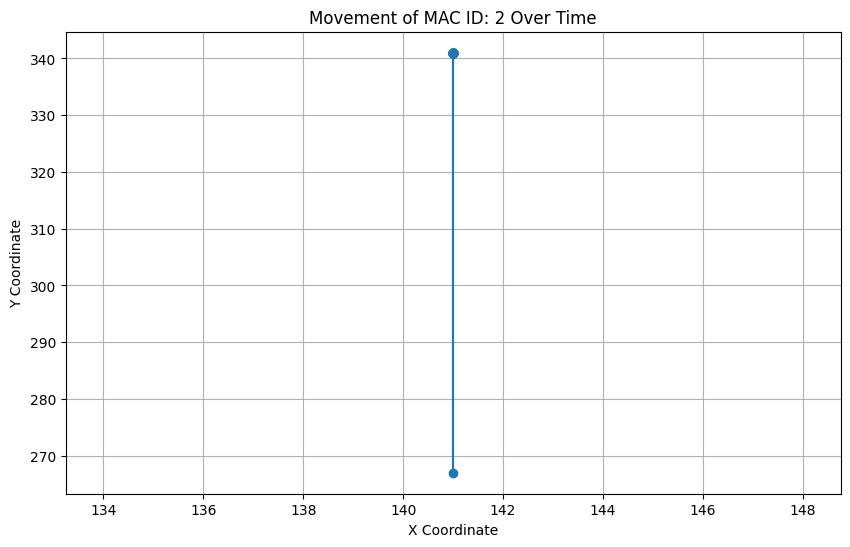

In [18]:
import matplotlib.pyplot as plt
import numpy as np


# Assuming 'mac_id' is the MAC address you want to visualize
mac_id = 2  # replace with the actual MAC address

# Extract the coordinates for the specific MAC address
mac_data = transformed_df[mac_id].dropna()  # Drop any NaNs

# Extract x and y coordinates
x_coords, y_coords = zip(*mac_data)
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_coords, y_coords, marker='o')  # Use 'scatter' instead of 'plot' for a scatter plot

plt.title(f'Movement of MAC ID: {mac_id} Over Time')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [19]:
mac_data

time
2023-11-02 14:00:00    (141, 341)
2023-11-02 14:01:00    (141, 341)
2023-11-02 14:02:00    (141, 341)
2023-11-02 14:03:00    (141, 341)
2023-11-02 14:04:00    (141, 341)
2023-11-02 14:05:00    (141, 341)
2023-11-02 14:06:00    (141, 341)
2023-11-02 14:07:00    (141, 341)
2023-11-02 14:08:00    (141, 341)
2023-11-02 14:09:00    (141, 341)
2023-11-02 14:10:00    (141, 341)
2023-11-02 14:11:00    (141, 341)
2023-11-02 14:12:00    (141, 341)
2023-11-02 14:13:00    (141, 341)
2023-11-02 14:14:00    (141, 341)
2023-11-02 14:15:00    (141, 341)
2023-11-02 14:16:00    (141, 341)
2023-11-02 14:17:00    (141, 341)
2023-11-02 14:18:00    (141, 267)
2023-11-02 14:19:00    (141, 341)
2023-11-02 14:20:00    (141, 341)
2023-11-02 14:21:00    (141, 341)
2023-11-02 14:22:00    (141, 341)
2023-11-02 14:23:00    (141, 341)
2023-11-02 14:24:00    (141, 341)
2023-11-02 14:25:00    (141, 341)
2023-11-02 14:26:00    (141, 341)
2023-11-02 14:27:00    (141, 341)
2023-11-02 14:28:00    (141, 341)
2023-11-0

In [20]:
x_coords, y_coords = zip(*mac_data)

y_coords

(341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 267,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341,
 341)

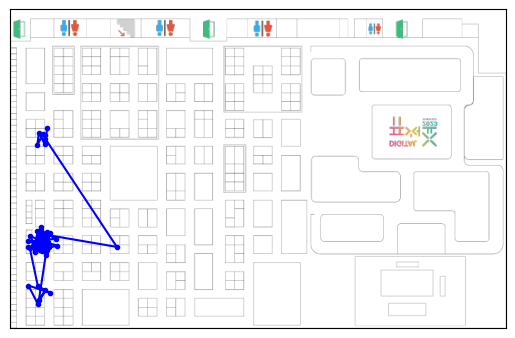

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as img
from matplotlib.animation import FuncAnimation


# Assuming 'mac_id' is the MAC address you want to visualize
mac_id = 3  # replace with the actual MAC address

# Extract the coordinates for the specific MAC address
mac_data = transformed_df[mac_id].dropna()  # Drop any NaNs

# Extract x and y coordinates
x_coords, y_coords = zip(*mac_data)

# Noise parameters
mean = 0  # Mean of the noise
std_dev = 10  # Standard deviation of the noise

# Generate noise for x and y coordinates
noise_x = np.random.normal(mean, std_dev, len(x_coords))
noise_y = np.random.normal(mean, std_dev, len(y_coords))

# Add noise to the original coordinates
noisy_x_coords = [x + noise for x, noise in zip(x_coords, noise_x)]
noisy_y_coords = [y + noise for y, noise in zip(y_coords, noise_y)]

fig, ax = plt.subplots()
ax.set_xlim([0, 700])  # Adjust these limits based on your data range
ax.set_ylim([0, 450])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

x, y = [], []

line, = ax.plot([], [], 'b.-')  # Initialize a line plot

def init():
    line.set_data([], [])
    return line,

def animate(frame):
    x.append(noisy_x_coords[frame])
    y.append(noisy_y_coords[frame])
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=len(x_coords), interval=1000, blit=True)
plt.imshow(plt.imread('background.png'))
anim.save('animation.gif', writer='pillow')
plt.show()
